In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 68s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


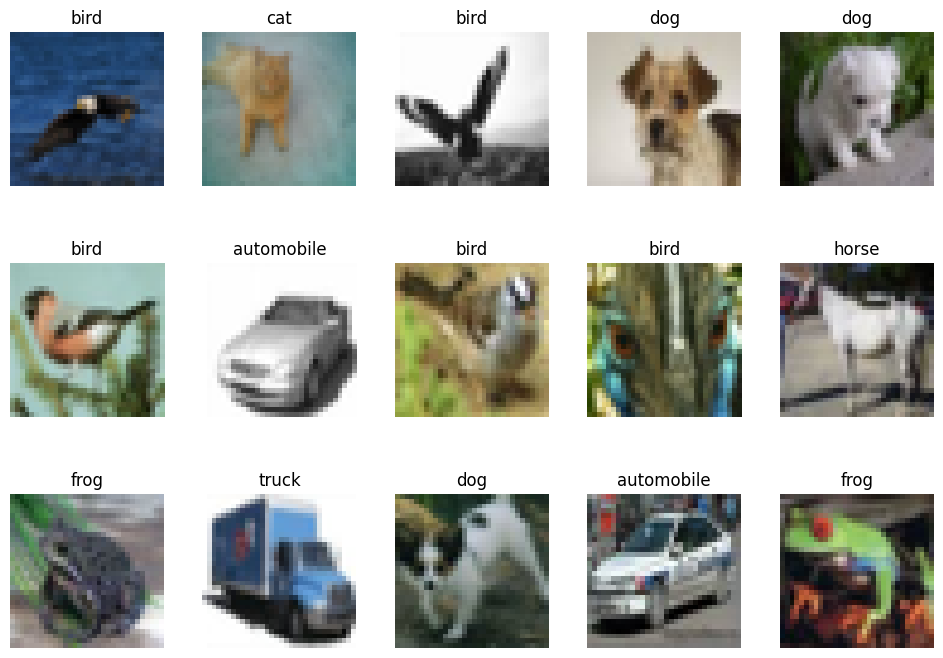

In [3]:
# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

C:\Users\Raman Tayal\AppData\Local\Temp\ipykernel_276\4180544181.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(class_names, rotation = 90)


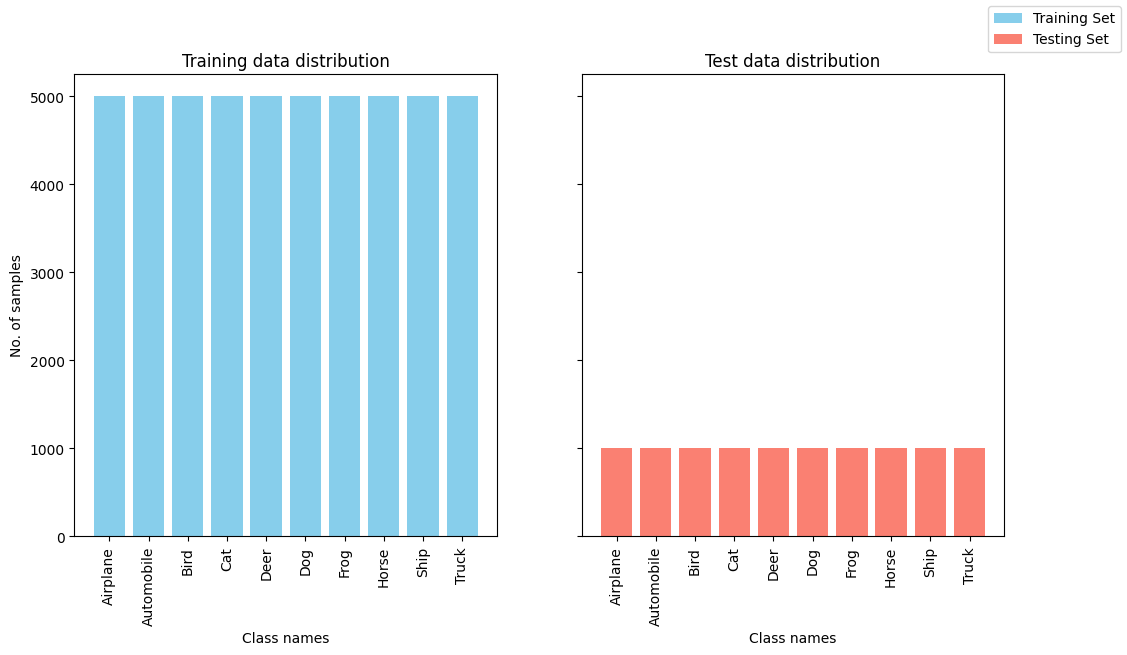

In [4]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

y_cat_train = to_categorical(y_train, 10)    # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors
y_cat_test = to_categorical(y_test, 10)      # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors

x_train1, x_valid, y_train1, y_valid= train_test_split(X_train, y_cat_train, test_size=0.2, random_state=22)


# Data augementation: Create a data augmentation function for the training and validation sets. During each iteration of training,
# the function will be applied randomly to batch of images to create diverse scenarios throughout the training

train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                    )
valid_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.21
                    )

#Data augmentation is not required, only normalization of the pixel values are required during the testing phase

test_datagen = ImageDataGenerator(rescale=1./255)


# # One-Hot Encoding
# y_cat_train = to_categorical(y_train1, 10)
# y_cat_valid = to_categorical(y_valid, 10)
# y_cat_test = to_categorical(y_test, 10)

In [ ]:
num_classes=10

#Compact model version
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
#Only after compilation, the weights are initialized and other hyper-parameters are considered for training to start

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]


#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


d:\Program Files\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100


d:\Program Files\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.4661 - loss: 1.4932 - val_accuracy: 0.5474 - val_loss: 1.2627
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.6123 - loss: 1.0963 - val_accuracy: 0.6202 - val_loss: 1.0589
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.6744 - loss: 0.9315 - val_accuracy: 0.6732 - val_loss: 0.9379
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.7095 - loss: 0.8312 - val_accuracy: 0.7106 - val_loss: 0.8239
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.7345 - loss: 0.7725 - val_accuracy: 0.7180 - val_loss: 0.8080
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.7482 - loss: 0.7271 - val_accuracy: 0.7527 - val_loss: 0.7114
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.7617 - loss: 0.6864 - val_accuracy: 0.7691 - val_loss: 0.6802
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.7738 - los

KeyboardInterrupt: 

NameError: name 'history' is not defined

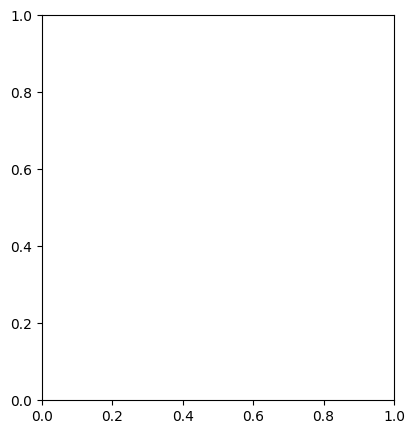

In [8]:
def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], marker='o', label='Train Loss')
  plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()


plot_convergence()


scores = model.evaluate(test_datagen.flow(X_test, y_cat_test,batch_size=32), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))